In [1]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

from DataClass import Data, MassData, Utils
from geo import Vector, Quaternion

# Util

In [2]:
def reject_outliers(data, m=3):
    return data[np.abs(data - np.mean(data)) < m*np.std(data)]

In [3]:
def reject_outliers_with_time(data, time, m=3):
    return data[np.abs(data - np.mean(data)) < m*np.std(data)], time[np.abs(data - np.mean(data)) < m*np.std(data)]

In [4]:
def rad_to_hz(rad, key):
    if key == 'lo':
        hi = 10
        lo = 8
    if key == 'med':
        hi = 11
        lo = 7
    if key == 'hi':
        hi = 12
        lo = 6

    m = (hi - lo) / np.pi
    c = (hi - np.pi) / 2 * m

    return m * rad + c


## Target/Actual Difference

In [5]:
def get_tango_angle(qx, qy, qz, qw):
    tango_orientation = Quaternion(x=qx, y=qy, z=qz, w=qw)
    tango_orientation.normalise()

    # Rotate Tango orientation to fall onto the world axis system
    rotate = Quaternion(vector=Vector(1, 0, 0), angle=np.pi/2)
    rotate.normalise()
    tango_orientation = tango_orientation.multiply(rotate)
    tango_orientation.normalise()

    tango_forward_vector = Vector(0.0, 0.0, -1.0)
    tango_forward_facing_vector = tango_forward_vector.rotate_vector(tango_orientation)

    tilt = np.arctan2(tango_forward_facing_vector.y, tango_forward_facing_vector.z)
    pan = np.arctan2(tango_forward_facing_vector.x, tango_forward_facing_vector.z)
        
    if tilt < -np.pi/2:
        tilt += np.pi
    elif tilt > np.pi/2:
        tilt -= np.pi
    if pan < -np.pi/2:
        pan += np.pi
    elif pan > np.pi/2:
        pan -= np.pi

    return pan, tilt

In [6]:
def get_target_tango_angle_bak(sample, tilt=True):
    
    tango_orientation = Quaternion(x=sample['qx'], y=sample['qy'], z=sample['qz'], w=sample['qw'])
    tango_orientation.normalise()

    # Rotate Tango orientation to fall onto the world axis system
    rotate = Quaternion(vector=Vector(1, 0, 0), angle=np.pi/2)
    rotate.normalise()
    tango_orientation = tango_orientation.multiply(rotate)
    tango_orientation.normalise()

    tango_forward_vector = Vector(0.0, 0.0, -1.0)
    tango_forward_facing_vector = tango_forward_vector.rotate_vector(tango_orientation)
    #tango_forward_facing_vector.normalise()

    vector_to_target = Vector(sample['tx'] - sample['x'], sample['ty'] - sample['z'], sample['tz'] - sample['y'])
    #vector_to_target.normalise()
    #rotate = Quaternion(vector=Vector(0, 0, 1), angle=math.pi)
    #rotate.normalise()
    #vector_to_target = vector_to_target.rotate_vector(rotate)
    #vector_to_target.normalise()

    if tilt:
        tango = np.arctan2(tango_forward_facing_vector.y, tango_forward_facing_vector.z)
        target = np.arctan2(vector_to_target.y, -vector_to_target.z)
    else:
        tango = np.arctan2(tango_forward_facing_vector.x, tango_forward_facing_vector.z)
        #tango = math.atan2(tango_forward_facing_vector.y, np.abs(tango_forward_facing_vector.z))
        target = np.arctan2(vector_to_target.x, -vector_to_target.z)
        
    if tango < -np.pi/2:
        tango += np.pi
    elif tango > np.pi/2:
        tango -= np.pi
    if target < -np.pi/2:
        target += np.pi
    elif target > np.pi/2:
        target -= np.pi

    return target, tango

In [7]:
def get_target_tango_angle(sample, tilt=True):
    
    tango_orientation = Quaternion(x=sample['qx'], y=sample['qy'], z=sample['qz'], w=sample['qw'])
    tango_orientation.normalise()

    # Rotate Tango orientation to fall onto the world axis system
    rotate = Quaternion(vector=Vector(1, 0, 0), angle=np.pi/2)
    rotate.normalise()
    tango_orientation = tango_orientation.multiply(rotate)
    tango_orientation.normalise()

    tango_forward_vector = Vector(0.0, 0.0, -1.0)
    tango_forward_facing_vector = tango_forward_vector.rotate_vector(tango_orientation)
    tango_forward_facing_vector.normalise()

    vector_to_target = Vector(sample['tx'] - sample['x'], sample['ty'] - sample['z'], sample['tz'] - sample['y'])
    vector_to_target.normalise()
    rotate = Quaternion(vector=Vector(0, 0, 1), angle=np.pi)
    rotate.normalise()
    vector_to_target = vector_to_target.rotate_vector(rotate)
    vector_to_target.normalise()

    if tilt:
        tango = np.arctan2(tango_forward_facing_vector.y, -tango_forward_facing_vector.z)
        target = np.arctan2(sample['ty'], -sample['tz'])
    else:
        tango = np.arctan2(tango_forward_facing_vector.x, -tango_forward_facing_vector.z)
        target = np.arctan2(sample['tx'], -sample['tz'])
        
    if tango < -np.pi/2:
        tango += np.pi
    elif tango > np.pi/2:
        tango -= np.pi
    if target < -np.pi/2:
        target += np.pi
    elif target > np.pi/2:
        target -= np.pi

    return target, -tango

In [8]:
def get_guesses_actual(data):
    pans = []
    tilts = []
    for sample in [data.get(i) for i in data.target_indices]:
        target, tango = get_target_tango_angle(sample, False)
        pans.append((target, tango))
        target, tango = get_target_tango_angle(sample, True)
        tilts.append((target, tango))
        
    return pans, tilts

## Angle errors

In [9]:
def get_angle_diff(sample, tilt=True):
    tango_orientation = Quaternion(x=sample['qx'], y=sample['qy'], z=sample['qz'], w=sample['qw'])
    tango_orientation.normalise()

    # Rotate Tango orientation to fall onto the world axis system
    rotate = Quaternion(vector=Vector(1, 0, 0), angle=-np.pi/2)
    rotate.normalise()
    tango_orientation = tango_orientation.multiply(rotate)
    tango_orientation.normalise()

    tango_forward_vector = Vector(0.0, 0.0, -1.0)
    tango_forward_facing_vector = tango_forward_vector.rotate_vector(tango_orientation)
    tango_forward_facing_vector.normalise()

    vector_to_target = Vector(sample['tx'] - sample['x'], sample['ty'] - sample['z'], sample['tz'] - sample['y'])
    vector_to_target.normalise()
    rotate = Quaternion(vector=Vector(0, 0, 1), angle=np.pi)
    rotate.normalise()
    vector_to_target = vector_to_target.rotate_vector(rotate)
    vector_to_target.normalise()

    if tilt:
        tango = Vector(0, tango_forward_facing_vector.y, tango_forward_facing_vector.z)
        tango.normalise()
        target = Vector(0, vector_to_target.y, vector_to_target.z)
        target.normalise()

        angle = tango.inv_dot_product(target)
        
        # Test to see if rotation is positive or negative
        test = tango.cross_product(target)
        if test.x < 0:
            angle = -angle

    else:
        tango = Vector(tango_forward_facing_vector.x, 0, tango_forward_facing_vector.z)
        tango.normalise()
        target = Vector(vector_to_target.x, 0, vector_to_target.z)
        target.normalise()

        angle = tango.inv_dot_product(target)
        
        # Test to see if rotation is positive or negative
        test = tango.cross_product(target)
        if test.y < 0:
            angle = -angle

    return angle

In [10]:
def get_error(data):
    pans = []
    tilts = []
    for sample in [data.get(i) for i in data.target_indices]:
        tilt = get_angle_diff(sample, tilt=True)
        if tilt < -np.pi/2:
            tilt += np.pi
        elif tilt > np.pi/2:
            tilt -= np.pi
        tilts.append(tilt)

        pan = get_angle_diff(sample, tilt=False)
        if pan < -np.pi/2:
            pan += np.pi
        elif pan > np.pi/2:
            pan -= np.pi
        pans.append(pan)
    return (pans, tilts)

# Data import

## Sighted

In [11]:
participant_list = glob.glob('/home/jaycee/workspace/data_processing/target_search/input/cleaned/sighted/*/*/')
data_s = {'med': [], 'lo': [], 'hi': []}

# Import data
for p in participant_list:
    for test in data_s.keys():
        for f in glob.glob(p + 'target/' + test + '/*.csv'):
            data_s[test].append(Data(f, 'target', test))

In [12]:
p_err_s = {'med': [], 'lo': [], 'hi': []}
t_err_s = {'med': [], 'lo': [], 'hi': []}

t_corr_s = {'med': [], 'lo': [], 'hi': []}
p_corr_s = {'med': [], 'lo': [], 'hi': []}

for test in data_s.keys():
    pe = []
    te = []
    pc = []
    tc = []
    for sample in data_s[test]:
        angles = get_error(sample)
        pe.append(angles[0])
        te.append(angles[1])

        angles = get_guesses_actual(sample)
        pc.append(angles[0])
        tc.append(angles[1])
    p_err_s[test] += pe
    t_err_s[test] += te
    p_corr_s[test] += pc
    t_corr_s[test] += tc

## Blind

In [53]:
participant_list = glob.glob('/home/jaycee/workspace/data_processing/target_search/input/cleaned/blind/*/*/')
#print(participant_list)
#participant_list = list(filter(lambda x: 'day8' not in x, participant_list))
#print(participant_list)
data_b = {'med': [], 'lo': [], 'hi': []}

# Import data
for p in participant_list:
    for test in data_b.keys():
        for f in glob.glob(p + 'target/' + test + '/*.csv'):
            data_b[test].append(Data(f, 'target', test))

In [54]:
p_err_b = {'med': [], 'lo': [], 'hi': []}
t_err_b = {'med': [], 'lo': [], 'hi': []}

t_corr_b = {'med': [], 'lo': [], 'hi': []}
p_corr_b = {'med': [], 'lo': [], 'hi': []}

for test in data_b.keys():
    pe = []
    te = []
    pc = []
    tc = []
    
    for sample in data_b[test]:
        angles = get_error(sample)
        pe.append(angles[0])
        te.append(angles[1])

        angles = get_guesses_actual(sample)
        pc.append(angles[0])
        tc.append(angles[1])
    p_err_b[test] += pe
    t_err_b[test] += te
    p_corr_b[test] += pc
    t_corr_b[test] += tc

# Results

## Combined

In [ ]:
#print(p_corr_s['hi'])
#print([x[0] for x in p_corr_s['hi'][0]])
#print([x[1] for x in p_corr_s['hi'][0]])
i = 0
t = 0
for d in p_corr_b['lo']:
    f, p = stats.pearsonr([x[0] for x in d], [x[1] for x in d])
    #print(f, p)
    t += 1
    if p < 0.05:
        i += 1
    plt.plot([x[0] for x in d], [x[1] for x in d], 'x')
print(i/t)
plt.show()

In [ ]:
tmp1 = []
tmp2 = []
for d in t_corr_s['lo']:
    f, p = stats.pearsonr([x[0] for x in d], [x[1] for x in d])
    if p < 0.05:
        tmp1.append([x[0] for x in d])
        tmp2.append([x[1] for x in d])
print(stats.pearsonr([x for x in [item for sublist in tmp1 for item in sublist]], [x for x in [item for sublist in tmp2 for item in sublist]]))

In [ ]:
for test in ['lo', 'med', 'hi']:
    print(test)
    #print([x[0] for x in [item for sublist in p_corr_s[test] for item in sublist]])
    print(stats.pearsonr([x[0] for x in [item for sublist in p_corr_s[test] for item in sublist]], [x[1] for x in [item for sublist in p_corr_s[test] for item in sublist]]))
    print(stats.pearsonr([x[0] for x in [item for sublist in t_corr_s[test] for item in sublist]], [x[1] for x in [item for sublist in t_corr_s[test] for item in sublist]]))
    print(stats.pearsonr([x[0] for x in [item for sublist in p_corr_b[test] for item in sublist]], [x[1] for x in [item for sublist in p_corr_b[test] for item in sublist]]))
    print(stats.pearsonr([x[0] for x in [item for sublist in t_corr_b[test] for item in sublist]], [x[1] for x in [item for sublist in t_corr_b[test] for item in sublist]]))

In [ ]:
for test in ['lo', 'med', 'hi']:
    print(test)
    print(stats.shapiro([item for sublist in p_err_s[test] for item in sublist]))
    print(stats.shapiro([item for sublist in t_err_s[test] for item in sublist]))
    print(stats.shapiro([item for sublist in p_err_b[test] for item in sublist]))
    print(stats.shapiro([item for sublist in t_err_b[test] for item in sublist]))

In [ ]:
f, ax = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(10, 10))
f.add_subplot(111, frameon=False)

bins = 30
a = {'lo': 0, 'med': 1, 'hi': 2}

for test in a:
    ax[a[test], 0].hist2d([item for sublist in p_err_s[test] for item in sublist], [item for sublist in t_err_s[test] for item in sublist], bins=bins, cmap='Greys')
    ax[a[test], 0].grid()
    ax[a[test], 0].tick_params(axis='both', which='major', labelsize=22)
    
    ax[a[test], 1].yaxis.set_label_position('right')
    ax[a[test], 1].yaxis.tick_right()
    ax[a[test], 1].set_ylabel(test, fontsize=22, rotation=0, labelpad=24)

    ax[a[test], 1].hist2d([item for sublist in p_err_b[test] for item in sublist], [item for sublist in t_err_b[test] for item in sublist], bins=bins, cmap='Greys')
    ax[a[test], 1].grid()
    ax[a[test], 1].tick_params(axis='both', which='major', labelsize=22)
    ax[a[test], 1].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
    ax[a[test], 1].set_yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])

ax[0, 0].set_title(r'$G1$', fontsize=22)

ax[0, 1].set_title(r'$G2$', fontsize=22)
ax[0, 1].set_xlim([-np.pi/2-0.2, np.pi/2+0.2])
ax[0, 1].set_ylim([-np.pi/2-0.2, np.pi/2+0.2])

#ax[1, 0].set_xticklabels([r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', 0, r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
#ax[1, 0].set_yticklabels([r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', 0, r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax[1, 0].set_xticklabels([r'$-\frac{\pi}{2}$', '', 0, '', r'$\frac{\pi}{2}$'])
ax[1, 0].set_yticklabels([r'$-\frac{\pi}{2}$', '', 0, '', r'$\frac{\pi}{2}$'])

plt.xlabel('Pan Error [rad]', fontsize=22, labelpad=24)
plt.ylabel('Tilt Error [rad]', fontsize=22, labelpad=24)

f.tight_layout()
f.text(0.55, 1.0, 'Target Errors', ha='center', fontsize=24)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')

plt.show()

## Boxplots

In [ ]:
for test in ['lo', 'med', 'hi']:
    t = [stats.shapiro(sample) if len(sample) > 3 else (0, 0) for sample in p_err_s[test]]
    p_sig_s = sum([1 if p > 0.05 else 0 for _, p in t])
    print('pan sighted: {}'.format(p_sig_s/len(t)))
    
    t = [stats.shapiro(sample) if len(sample) > 3 else (0, 0) for sample in t_err_s[test]]
    t_sig_s = sum([1 if p > 0.05 else 0 for _, p in t])
    print('tilt sighted: {}'.format(t_sig_s/len(t)))
    
    t = [stats.shapiro(sample) if len(sample) > 3 else (0, 0) for sample in p_err_b[test]]
    p_sig_b = sum([1 if p > 0.05 else 0 for _, p in t])
    print('pan blind: {}'.format(p_sig_b/len(t)))
    
    t = [stats.shapiro(sample) if len(sample) > 3 else (0, 0) for sample in t_err_b[test]]
    t_sig_b = sum([1 if p > 0.05 else 0 for _, p in t])
    print('tilt blind: {}'.format(t_sig_b/len(t)))

In [ ]:
for test in ['lo', 'med', 'hi']:
    print(stats.shapiro([np.median(x) for x in t_err_s[test] if len(x) > 0]))

In [ ]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 7))
f.add_subplot(111, frameon=False)

a = {'lo': 0, 'med': 1, 'hi': 2}

bp = ax[0].boxplot([[np.median(x) for x in p_err_s['lo'] if len(x) > 0], [np.median(x) for x in p_err_s['med'] if len(x) > 0], [np.median(x) for x in p_err_s['hi']]], positions=[0.8, 1.8, 2.8], showfliers=False, patch_artist=True)
ax[0].boxplot([[np.median(x) for x in t_err_s['lo'] if len(x) > 0], [np.median(x) for x in t_err_s['med'] if len(x) > 0], [np.median(x) for x in t_err_s['hi']]], positions=[1.2, 2.2, 3.2], showfliers=False)
ax[0].set_ylim([-np.pi/3, np.pi/3])
ax[0].set_xlim([0.5, 3.5])
ax[0].grid(axis='y')
ax[0].set_yticks([-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9])
ax[0].set_xticks([1.0, 2.0, 3.0])
ax[0].set_xticklabels(['lo', 'med', 'hi'], fontsize=22)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].set_title(r'$G1$', fontsize=22)
ax[0].set_ylabel('Angle Error [rad]', fontsize=24)

for box in bp['boxes']:
    box.set(hatch='/')
    box.set(fill=False)

bp0 = ax[1].boxplot([[np.median(x) for x in p_err_b['lo']], [np.median(x) for x in p_err_b['med']], [np.median(x) for x in p_err_b['hi'] if len(x) > 0]], positions=[0.8, 1.8, 2.8], showfliers=False, patch_artist=True)
bp1 = ax[1].boxplot([[np.median(x) for x in t_err_b['lo']], [np.median(x) for x in t_err_b['med']], [np.median(x) for x in t_err_b['hi'] if len(x) > 0]], positions=[1.2, 2.2, 3.2], showfliers=False, patch_artist=True)
ax[1].grid(axis='y')
ax[1].set_xlim([0.5, 3.5])
ax[1].set_xticks([1.0, 2.0, 3.0])
ax[1].set_xticklabels(['lo', 'med', 'hi'], fontsize=22)
ax[1].set_title(r'$G2$', fontsize=22)
#ax[1].legend(['Pan Error', 'Tilt Error'], fontsize=18)

for b0, b1 in zip(bp0['boxes'], bp1['boxes']):
    b0.set(hatch='/')
    b0.set(fill=False)
    b1.set(fill=False)
    b0.set_label('Pan')
ax[1].legend([bp0['boxes'][0], bp1['boxes'][0]], ['Pan', 'Elevation'], fontsize=18)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
f.tight_layout()
f.text(0.55, 1.0, 'Medians of the Angular Errors', ha='center', fontsize=24)
plt.show()

In [ ]:
print(len([np.median(x) for x in p_err_b['hi'] if len(x) > 0]))

print('Sighted pan: {}'.format(stats.friedmanchisquare(
    [np.median(x) for x in p_err_s['lo'] if len(x) > 0],
    [np.median(x) for x in p_err_s['med'] if len(x) > 0] + [0.0, 0.0, 0.0],
    [np.median(x) for x in p_err_s['hi'] if len(x) > 0] + [0.0]
)))
print('Sighted tilt: {}'.format(stats.friedmanchisquare(
    [np.median(x) for x in t_err_s['lo'] if len(x) > 0],
    [np.median(x) for x in t_err_s['med'] if len(x) > 0] + [0.0, 0.0, 0.0],
    [np.median(x) for x in t_err_s['hi'] if len(x) > 0] + [0.0]
)))

print('Blind pan: {}'.format(stats.friedmanchisquare(
    [np.median(x) for x in p_err_b['lo'] if len(x) > 0],
    [np.median(x) for x in p_err_b['med'] if len(x) > 0],
    [np.median(x) for x in p_err_b['hi'] if len(x) > 0]
)))
print('Blind tilt: {}'.format(stats.friedmanchisquare(
    [np.median(x) for x in t_err_b['lo'] if len(x) > 0],
    [np.median(x) for x in t_err_b['med'] if len(x) > 0],
    [np.median(x) for x in t_err_b['hi'] if len(x) > 0]
)))

In [ ]:
print(len([item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_b['hi']] for item in sublist]))

print('Sighted pan: {}'.format(stats.friedmanchisquare(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_s['lo']] for item in sublist] + [0.0 for i in range(30)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_s['med']] for item in sublist] + [0.0 for i in range(50)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_s['hi']] for item in sublist]
)))
print('Sighted tilt: {}'.format(stats.friedmanchisquare(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['lo']] for item in sublist] + [0.0 for i in range(30)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['med']] for item in sublist] + [0.0 for i in range(50)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['hi']] for item in sublist]
)))

print('Blind pan: {}'.format(stats.friedmanchisquare(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_b['lo']] for item in sublist] + [0.0 for i in range(17)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_b['med']] for item in sublist] + [0.0 for i in range(22)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_b['hi']] for item in sublist]
)))

print('Blind tilt: {}'.format(stats.friedmanchisquare(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['lo']] for item in sublist] + [0.0 for i in range(17)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['med']] for item in sublist] + [0.0 for i in range(22)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['hi']] for item in sublist]
)))

In [ ]:
print('Sighted tilt (lo med): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['lo']] for item in sublist] + [0.0 for i in range(30)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['med']] for item in sublist] + [0.0 for i in range(50)], 
)))
print('Sighted tilt (lo hi): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['lo']] for item in sublist] + [0.0 for i in range(30)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['hi']] for item in sublist], 
)))
print('Sighted tilt (med hi): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['med']] for item in sublist] + [0.0 for i in range(50)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['hi']] for item in sublist], 
)))

In [ ]:
print('Blind tilt (lo med): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['lo']] for item in sublist] + [0.0 for i in range(17)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['med']] for item in sublist] + [0.0 for i in range(22)], 
)))
print('Blind tilt (lo hi): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['lo']] for item in sublist] + [0.0 for i in range(17)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['hi']] for item in sublist], 
)))
print('Blind tilt (med hi): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['hi']] for item in sublist][:-22], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['med']] for item in sublist], 
)))

In [ ]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 7))
f.add_subplot(111, frameon=False)

a = {'lo': 0, 'med': 1, 'hi': 2}

bp = ax[0].boxplot([[np.median(np.abs(x)) for x in p_err_s['lo'] if len(x) > 0], [np.median(np.abs(x)) for x in p_err_s['med'] if len(x) > 0], [np.median(np.abs(x)) for x in p_err_s['hi']]], positions=[0.8, 1.8, 2.8], showfliers=False, patch_artist=True)
ax[0].boxplot([[np.median(np.abs(x)) for x in t_err_s['lo'] if len(x) > 0], [np.median(np.abs(x)) for x in t_err_s['med'] if len(x) > 0], [np.median(np.abs(x)) for x in t_err_s['hi']]], positions=[1.2, 2.2, 3.2], showfliers=False)
ax[0].set_ylim([0, np.pi/3])
ax[0].set_xlim([0.5, 3.5])
ax[0].grid(axis='y')
ax[0].set_yticks(np.arange(0, 1.01, 0.25))
ax[0].set_xticks([1.0, 2.0, 3.0])
ax[0].set_xticklabels(['lo', 'med', 'hi'], fontsize=22)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].set_title(r'$G1$', fontsize=22)
ax[0].set_ylabel('Angle Error [rad]', fontsize=24)

for box in bp['boxes']:
    box.set(hatch='/')
    box.set(fill=False)

bp0 = ax[1].boxplot([[np.median(np.abs(x)) for x in p_err_b['lo']], [np.median(np.abs(x)) for x in p_err_b['med']], [np.median(np.abs(x)) for x in p_err_b['hi'] if len(x) > 0]], positions=[0.8, 1.8, 2.8], showfliers=False, patch_artist=True)
bp1 = ax[1].boxplot([[np.median(np.abs(x)) for x in t_err_b['lo']], [np.median(np.abs(x)) for x in t_err_b['med']], [np.median(np.abs(x)) for x in t_err_b['hi'] if len(x) > 0]], positions=[1.2, 2.2, 3.2], showfliers=False, patch_artist=True)
ax[1].grid(axis='y')
ax[1].set_xlim([0.5, 3.5])
ax[1].set_xticks([1.0, 2.0, 3.0])
ax[1].set_xticklabels(['lo', 'med', 'hi'], fontsize=22)
ax[1].set_title(r'$G2$', fontsize=22)
#ax[1].legend(['Pan Error', 'Tilt Error'], fontsize=18)

for b0, b1 in zip(bp0['boxes'], bp1['boxes']):
    b0.set(hatch='/')
    b0.set(fill=False)
    b1.set(fill=False)
    b0.set_label('Pan')
ax[0].legend([bp0['boxes'][0], bp1['boxes'][0]], ['Pan', 'Elevation'], fontsize=18)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
f.tight_layout()
f.text(0.55, 1.0, 'Medians of the Absolute Angular Errors', ha='center', fontsize=24)
plt.show()

In [ ]:
for test in ['lo', 'med', 'hi']:
    print(test)
    print(stats.shapiro([np.median(np.abs(x)) for x in p_err_s[test] if len(x) > 0]))
    print(stats.shapiro([np.median(np.abs(x)) for x in t_err_s[test] if len(x) > 0]))
    print(stats.shapiro([np.median(np.abs(x)) for x in p_err_b[test] if len(x) > 0]))
    print(stats.shapiro([np.median(np.abs(x)) for x in t_err_b[test] if len(x) > 0]))

In [ ]:
print('Sighted pan: {}'.format(stats.kruskal([np.median(np.abs(x)) for x in p_err_s['lo'] if len(x) > 0], [np.median(np.abs(x)) for x in p_err_s['med'] if len(x) > 0], [np.median(np.abs(x)) for x in p_err_s['hi'] if len(x) > 0])))
print('Signted tilt: {}'.format(stats.kruskal([np.median(np.abs(x)) for x in t_err_s['lo'] if len(x) > 0], [np.median(np.abs(x)) for x in t_err_s['med'] if len(x) > 0], [np.median(np.abs(x)) for x in t_err_s['hi'] if len(x) > 0])))
print('Blind pan: {}'.format(stats.kruskal([np.median(np.abs(x)) for x in p_err_b['lo'] if len(x) > 0], [np.median(np.abs(x)) for x in p_err_b['med'] if len(x) > 0], [np.median(np.abs(x)) for x in p_err_b['hi'] if len(x) > 0])))
print('Blind tilt: {}'.format(stats.kruskal([np.median(np.abs(x)) for x in t_err_b['lo'] if len(x) > 0], [np.median(np.abs(x)) for x in t_err_b['med'] if len(x) > 0], [np.median(np.abs(x)) for x in t_err_b['hi'] if len(x) > 0])))

In [ ]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 7))
f.add_subplot(111, frameon=False)

a = {'lo': 0, 'med': 1, 'hi': 2}

ax[0].boxplot([[np.std(x) for x in p_err_s['lo'] if len(x) > 0], [np.std(x) for x in p_err_s['med'] if len(x) > 0], [np.std(x) for x in p_err_s['hi']]], positions=[0.8, 1.8, 2.8], showfliers=False)
ax[0].boxplot([[np.std(x) for x in t_err_s['lo'] if len(x) > 0], [np.std(x) for x in t_err_s['med'] if len(x) > 0], [np.std(x) for x in t_err_s['hi']]], positions=[1.2, 2.2, 3.2], showfliers=False)
ax[0].set_ylim([0, np.pi/4])
ax[0].set_xlim([0.5, 3.5])
ax[0].grid()

ax[1].boxplot([[np.std(x) for x in p_err_b['lo']], [np.std(x) for x in p_err_b['med']], [np.std(x) for x in p_err_b['hi'] if len(x) > 0]], positions=[0.8, 1.8, 2.8], showfliers=False)
ax[1].boxplot([[np.std(x) for x in t_err_b['lo']], [np.std(x) for x in t_err_b['med']], [np.std(x) for x in t_err_b['hi'] if len(x) > 0]], positions=[1.2, 2.2, 3.2], showfliers=False)
ax[1].grid()
ax[1].set_xlim([0.5, 3.5])

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.tight_layout()
plt.show()

## Fitts Relationship

In [15]:
def func_fitts(x, a, b):
    return a + b*x

In [55]:
def fitts_id(x, we):
    return np.log2(2*np.array(x)/we)

1.0149861916951937


/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.017313512191582
1.017299364118952
1.0073147402013423
1.1409520672997706
0.9445765336684593


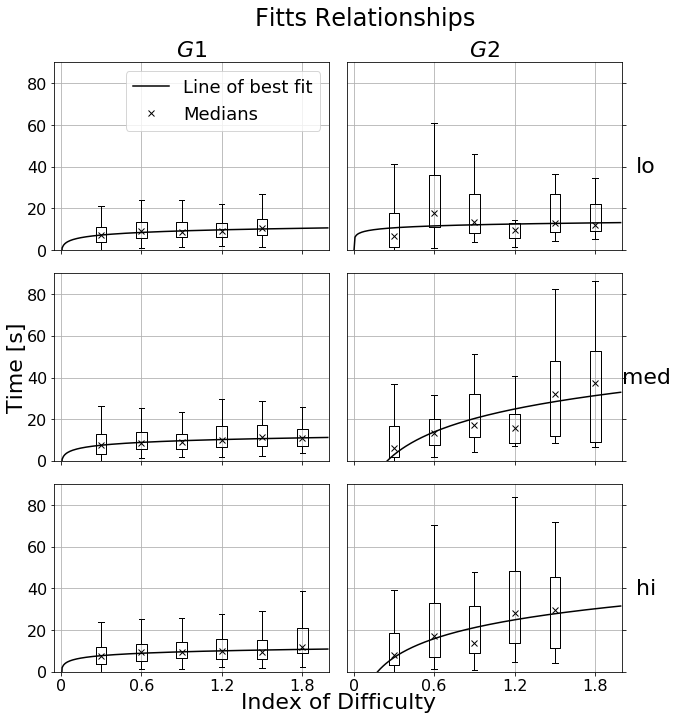

In [66]:
f, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10, 10))
f.add_subplot(111, frameon=False)

tests = {'lo': ax[0, 0], 'med': ax[1, 0], 'hi': ax[2, 0]}
x = np.arange(1e-5, 2, 0.01)
step = 0.3

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_s[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
            
    we = 4.133*np.std(anglediff)
    print(we)

    ids = [fitts_id(x, we) for x in anglediff]

    bins = np.arange(1e-5, np.max(ids), step)
    ind = np.digitize(np.power(2, ids), bins)

    timebox = [[] for i in range(len(bins))]
    for i in range(len(timediff)):
        timebox[ind[i]-1].append(timediff[i])
    fmedians = [np.median(t) for t in timebox if len(t) > 0].copy()
    fx = (bins+step).copy()
    fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins+step, we), [np.median(t) for t in timebox if len(t) > 0])

    tests[test].boxplot(timebox, positions=np.round(bins+step, 2), showfliers=False, medianprops=dict(linestyle=None, linewidth=0), widths=0.08)
    tests[test].plot(x, fopt[0]+fopt[1]*fitts_id(x, we), 'k', label='Line of best fit')
    tests[test].plot(bins+step, [np.median(t) for t in timebox if len(t) > 0], 'kx', label='Medians')
    #tests[test].set_title(test, fontsize=22)
    tests[test].set_xticks([0, 0.6, 1.2, 1.8])
    tests[test].grid()
    tests[test].tick_params(axis='both', which='major', labelsize=16)
tests = {'lo': ax[0, 1], 'med': ax[1, 1], 'hi': ax[2, 1]}

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_b[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()

    we = 4.133*np.std(anglediff)
    print(we)

    ids = [fitts_id(x, we) for x in anglediff]

    bins = np.arange(1e-5, np.max(ids), step)
    ind = np.digitize(np.power(2, ids), bins)

    timebox = [[] for i in range(len(bins))]
    for i in range(len(timediff)):
        timebox[ind[i]-1].append(timediff[i])
    fmedians = [np.median(t) for t in timebox if len(t) > 0].copy()
    fx = (bins+step).copy()
    fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins+step, we), [np.median(t) for t in timebox if len(t) > 0])

    tests[test].boxplot(timebox, positions=np.round(bins+step, 2), showfliers=False, medianprops=dict(linestyle=None, linewidth=0), widths=0.08)
    tests[test].plot(x, fopt[0]+fopt[1]*fitts_id(x, we), 'k', label='Line of best fit')
    tests[test].plot(bins+step, [np.median(t) for t in timebox if len(t) > 0], 'kx', label='Medians')
    #tests[test].set_title(test, fontsize=22)
    tests[test].set_xticks([0, 0.6, 1.2, 1.8])
    tests[test].grid()
    tests[test].tick_params(axis='both', which='major', labelsize=16)
    
    tests[test].yaxis.set_label_position('right')
    tests[test].yaxis.tick_right()
    tests[test].set_ylabel(test, fontsize=22, rotation=0, labelpad=24)

ax[0, 0].legend(fontsize=18)
ax[0, 0].set_title(r'$G1$', fontsize=22)
ax[0, 1].set_title(r'$G2$', fontsize=22)
#ax[0, 0].set_ylim((0, 50))
ax[1, 0].set_ylim((0, 90))

ax[1, 0].set_xticklabels([0, 0.6, 1.2, 1.8])
ax[1, 1].set_xticklabels([0, 0.6, 1.2, 1.8])

ax[1, 0].set_xlim((-0.05, 2))
ax[1, 1].set_xlim((-0.05, 2))

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.ylabel('Time [s]', fontsize=22)
plt.xlabel('Index of Difficulty', fontsize=22)

f.text(0.55, 1.0, 'Fitts Relationships', ha='center', fontsize=24)
f.tight_layout()
plt.show()

In [80]:
tests = {'lo': 0, 'med': 0, 'hi': 0}
x = np.arange(1e-5, 2, 0.01)
step = 0.3

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_b[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
    print(test)

    we = 4.133*np.std(anglediff)
    print(we)

    ids = [fitts_id(x, we) for x in anglediff]

    bins = np.arange(1e-5, np.max(ids), step)
    ind = np.digitize(np.power(2, ids), bins)

    timebox = [[] for i in range(len(bins))]
    for i in range(len(timediff)):
        timebox[ind[i]-1].append(timediff[i])
    fmedians = [np.median(t) for t in timebox if len(t) > 0].copy()
    fx = (bins+step).copy()
    fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins+step, we), [np.median(t) for t in timebox if len(t) > 0])
    x = fitts_id(bins+step, we)
    y_fit = fopt[0]+fopt[1]*x
    y_true = [np.median(t) for t in timebox if len(t) > 0]
    print(y_fit, y_true)
    print(stats.shapiro(y_fit), stats.shapiro(y_true))
    print(stats.pearsonr(y_fit, y_true))

lo
1.0073147402013423
[10.64850956 11.56055098 12.09406653 12.47260337 12.76621999 13.00612257] [6.893847999999707, 17.83983500000022, 13.558774999997695, 9.421687999999904, 13.044291999998677, 11.789635000000317]
(0.9374852180480957, 0.6390087604522705) (0.9817688465118408, 0.9600049257278442)
(0.2324667071520835, 0.6575812791911497)
med
1.1409520672997706
[ 2.90405222 13.9000229  20.33231994 24.89612578 28.43609635 31.32846688] [6.247499999999491, 13.169690000009723, 17.285179499996048, 15.667524999997113, 32.087541499999816, 37.3396479999999]
(0.9374850392341614, 0.6390076279640198) (0.9142405390739441, 0.46487629413604736)
(0.8833067196269401, 0.019631457557724618)
hi
0.9445765336684593
[ 6.82219891 15.88376287 21.1844928  24.94543576 27.86265614] [8.032320000000254, 16.957507000000078, 14.047612592499718, 28.146251999999777, 29.514854999999898]
(0.9471778869628906, 0.71701979637146) (0.9124125242233276, 0.4822232127189636)
(0.8976811937049449, 0.03868002895253205)


/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/jaycee/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/jaycee/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[60, 58, 59]
FriedmanchisquareResult(statistic=79.74058577405854, pvalue=4.8367295855099314e-18)
lo med WilcoxonResult(statistic=281.0, pvalue=3.052484624609796e-06)
lo hi WilcoxonResult(statistic=60.0, pvalue=3.09047858118837e-10)
hi med WilcoxonResult(statistic=309.0, pvalue=1.3761389355681974e-05)
[16, 16, 17]
FriedmanchisquareResult(statistic=4.507462686567161, pvalue=0.10500667669407686)


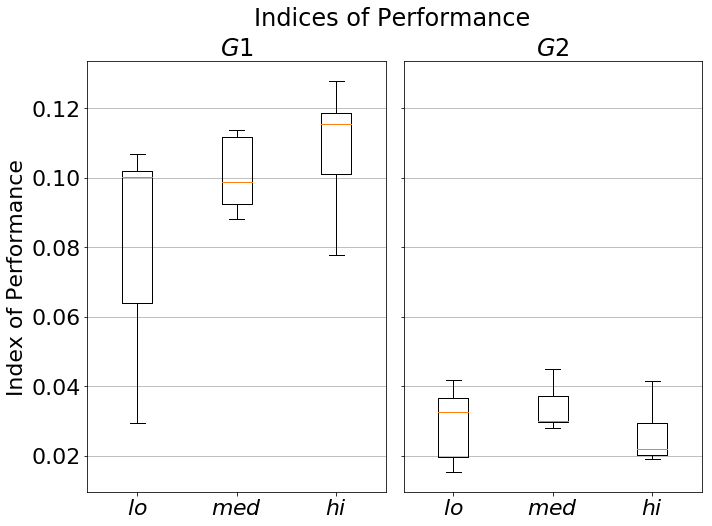

In [95]:
tests = {'lo': 1.015, 'med': 1.017, 'hi': 1.017} # sighted
ips = {'lo': [], 'med': [], 'hi': []}
step = 0.3

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_s[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
        #we = 4.133*np.std(anglediff)

        ids = [fitts_id(x, tests[test]) for x in anglediff]
        if len(ids) == 0:
            continue
        #print(ids)
        bins = np.arange(1e-5, np.max(ids), step)
        ind = np.digitize(np.power(2, ids), bins)

        timebox = [[] for i in range(len(bins))]
        for i in range(len(timediff)):
            timebox[ind[i]-1].append(timediff[i])
        #fmedians = [np.median(t) for t in timebox if len(t) > 0].copy()
        #fx = (bins+step).copy()
        #print(fitts_id(bins+step, we), [np.median(t) for t in timebox if len(t) > 0])
        fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins+step, we), [np.median(t) if len(t) > 0 else 0.0 for t in timebox ])
        x = fitts_id(bins+step, we)
        #print(x, fopt[0]+fopt[1]*x)
        ips[test].append(np.median(x/(fopt[0]+fopt[1]*x)))
#print(ips)
print([len(ips[test]) for test in ips.keys()])
print(stats.friedmanchisquare(ips['lo'], ips['med']+[0, 0], ips['hi']+[0]))
#print(stats.friedmanchisquare(ips['lo'][:-2], ips['med'], ips['hi'][:-1]))
print('lo med {}'.format(stats.wilcoxon(ips['lo'], ips['med']+[0,0])))
print('lo hi {}'.format(stats.wilcoxon(ips['lo'], ips['hi']+[0])))
print('hi med {}'.format(stats.wilcoxon(ips['hi'], ips['med']+[0])))

f, ax = plt.subplots(1, 2, figsize=(10, 7), sharex=True, sharey=True)

ax[0].boxplot([ips['lo'], ips['med'], ips['hi']], showfliers=False, labels=[r'$lo$', r'$med$', r'$hi$'])
#ax[0].set_title('Indices of Performance', fontsize=24)
ax[0].set_ylabel('Index of Performance', fontsize=22)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].grid(axis='y')
ax[0].set_title(r'$G1$', fontsize=24)

tests = {'lo': 1.00, 'med': 1.14, 'hi': 0.95} # blind
ips = {'lo': [], 'med': [], 'hi': []}

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_b[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
        #we = 4.133*np.std(anglediff)

        ids = [fitts_id(x, tests[test]) for x in anglediff]
        if len(ids) == 0:
            continue
        #print(ids)
        bins = np.arange(1e-5, np.max(ids), step)
        ind = np.digitize(np.power(2, ids), bins)

        timebox = [[] for i in range(len(bins))]
        for i in range(len(timediff)):
            timebox[ind[i]-1].append(timediff[i])
        #fmedians = [np.median(t) for t in timebox if len(t) > 0].copy()
        #fx = (bins+step).copy()
        #print(fitts_id(bins+step, we), [np.median(t) for t in timebox if len(t) > 0])
        fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins+step, we), [np.median(t) if len(t) > 0 else 0.0 for t in timebox ])
        x = fitts_id(bins+step, we)
        #print(x, fopt[0]+fopt[1]*x)
        ips[test].append(np.median(x/(fopt[0]+fopt[1]*x)))
print([len(ips[test]) for test in ips.keys()])
print(stats.friedmanchisquare(ips['lo']+[0], ips['med']+[0], ips['hi']))
#print(stats.friedmanchisquare(ips['lo'], ips['med'], ips['hi'][:-1]))
        
ax[1].boxplot([ips['lo'], ips['med'], ips['hi']], showfliers=False, labels=[r'$lo$', r'$med$', r'$hi$'])
#ax[0].set_title('Indices of Performance', fontsize=24)
#ax[0].set_ylabel('Index of Performance', fontsize=22)
#ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].grid(axis='y')
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[1].set_title(r'$G2$', fontsize=24)

f.text(0.55, 1.0, 'Indices of Performance', ha='center', fontsize=24)
f.tight_layout()
plt.show()

In [ ]:
datasets = {}
glob_pan = []
glob_tilt = []
for key in ['lo', 'med', 'hi']:
    pan = []
    tilt = []
    for dset in data_b[key]:
        code = dset.file.split('/')[10]
        if code not in datasets.keys():
            datasets[code] = {}
        datasets[code][key] = {}
        datasets[code][key]['pan'] = []
        datasets[code][key]['tilt'] = []
        pans, tilts = get_error(dset)
        if len(pans) != 0 and len(tilts) != 0:
            datasets[code][key]['pan'].append(np.median(pans))
            datasets[code][key]['tilt'].append(np.median(np.array(tilts)))
            pan.append(np.median(pans))
            tilt.append(np.median(tilts))
            # pans.append(np.median(pan))
            # tilts.append(np.median(tilt))
    glob_pan.append(pan)
    glob_tilt.append(tilt)
pans = []
tilts = []
for code in datasets.keys():
    pan = []
    tilt = []
    for key in datasets[code].keys():
        if len(datasets[code][key]['tilt']) != 0:
            pan.append(datasets[code][key]['pan'])
            tilt.append(datasets[code][key]['tilt'][0])
    tilts.append(tilt)
    pans.append(pan)

f, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(14, 7))
f.add_subplot(111, frameon=False)

hatch = {'lo': '/', 'med': 'x', 'hi': 'o'}
for key in ['lo', 'med', 'hi']:
    nbins = 5
    data = [datasets[code][key]['tilt'][0] if len(datasets[code][key]['tilt']) != 0 else 0.0 for code in datasets.keys()]
    data = [rad_to_hz(data[i], key) for i in range(len(data))]
    # hist, bins = np.histogram(np.log2(data), normed=False, bins=int(nbins))
    hist, bins = np.histogram(data, density=False, bins=int(nbins))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    nsamples = len(data)*3
    ax[0].bar(center, hist/nsamples, align='center', width=width, label=key, fill=False, hatch=hatch[key])
ax[0].plot([2**(1/0.2854498373089882), 2**(1/0.2854498373089882)], [0, 0.18], 'k--', label='Median Cut-Off')
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].set_ylabel('Number of Samples [normalised]', fontsize=24)
#ax[0].set_yticks(np.arange(0, 0.176, 0.025))
#ax[0].set_yticklabels(np.arange(0, 0.176, 0.025))
ax[0].set_title(r'$G1$', fontsize=22)
ax[0].legend(fontsize=18)
ax[0].grid()

glob_pan = []
glob_tilt = []
for key in ['lo', 'med', 'hi']:
    pan = []
    tilt = []
    for dset in data_s[key]:
        code = dset.file.split('/')[10]
        if code not in datasets.keys():
            datasets[code] = {}
        datasets[code][key] = {}
        datasets[code][key]['pan'] = []
        datasets[code][key]['tilt'] = []
        pans, tilts = get_error(dset)
        if len(pans) != 0 and len(tilts) != 0:
            datasets[code][key]['pan'].append(np.median(pans))
            datasets[code][key]['tilt'].append(np.median(np.array(tilts)))
            pan.append(np.median(pans))
            tilt.append(np.median(tilts))
            # pans.append(np.median(pan))
            # tilts.append(np.median(tilt))
    glob_pan.append(pan)
    glob_tilt.append(tilt)
pans = []
tilts = []
for code in datasets.keys():
    pan = []
    tilt = []
    for key in datasets[code].keys():
        if len(datasets[code][key]['tilt']) != 0:
            pan.append(datasets[code][key]['pan'])
            tilt.append(datasets[code][key]['tilt'][0])
    tilts.append(tilt)
    pans.append(pan)

hatch = {'lo': '/', 'med': 'x', 'hi': 'o'}
for key in ['lo', 'med', 'hi']:
    nbins = 5
    data = [datasets[code][key]['tilt'][0] if len(datasets[code][key]['tilt']) != 0 else 0.0 for code in datasets.keys()]
    data = [rad_to_hz(data[i], key) for i in range(len(data))]
    # hist, bins = np.histogram(np.log2(data), normed=False, bins=int(nbins))
    hist, bins = np.histogram(data, density=False, bins=int(nbins))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    nsamples = len(data)*3
    ax[1].bar(center, hist/nsamples, align='center', width=width, label=key, fill=False, hatch=hatch[key])
ax[1].plot([2**(1/0.3506489946182825), 2**(1/0.3506489946182825)], [0, 0.18], 'k--')
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[1].set_title(r'$G2$', fontsize=22)
ax[1].grid()

f.text(0.55, -0.01, 'Sound Frequency [Hz]', ha='center', fontsize=24)
f.text(0.55, 1.0, '75% Cut-Off Thresholds', ha='center', fontsize=24)
f.tight_layout()
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.show()